In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()
# Use the Base class to reflect the database tables
Base.prepare(engine, reflect=True)

/var/folders/s2/zfm4_lwj4fndcl2y79v_vx180000gn/T/ipykernel_77244/3601434573.py:4: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# Print all of the classes mapped to the Base
print(Base.classes.keys())

['station', 'measurement']


In [9]:
# Assign the measurement class to a variable called `Measurement` and
# the station class to a variable called `Station`
Measurement = Base.classes.measurement
Station = Base.classes.station

In [11]:
# Create a session
session = Session(engine)
session

# Exploratory Precipitation Analysis

In [15]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(recent_date[0])

2017-08-23


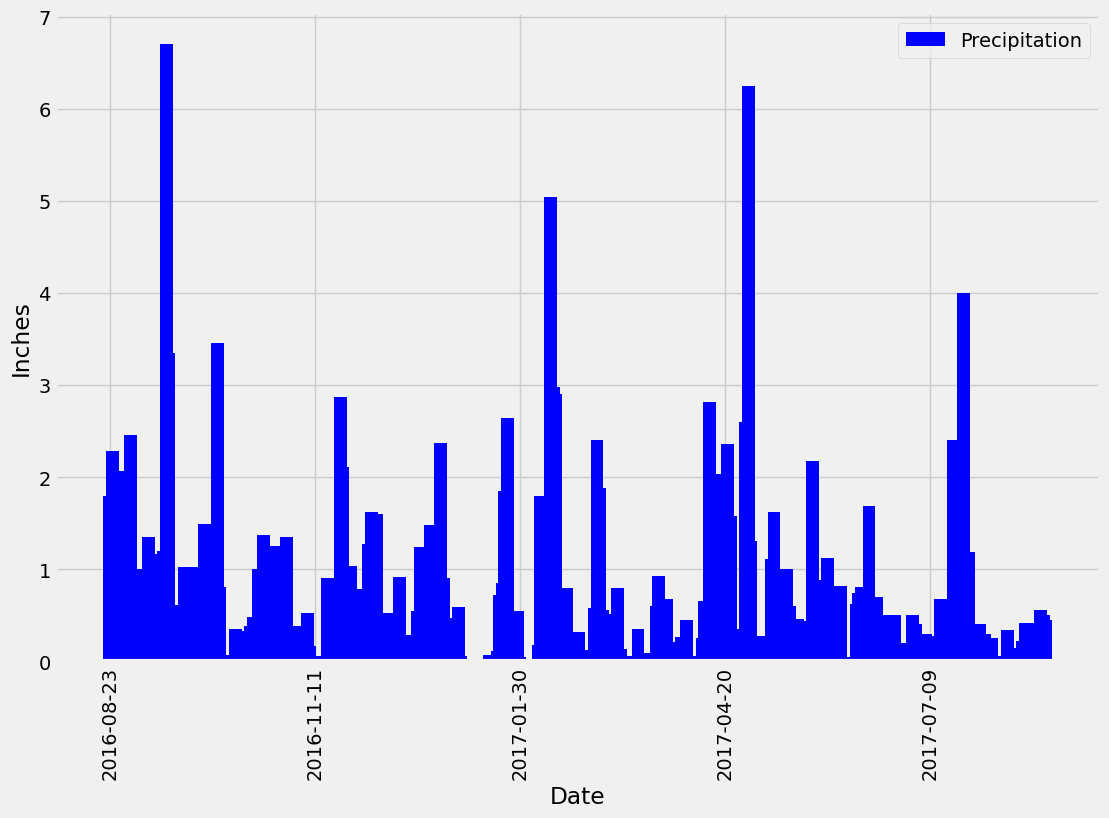

In [54]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
latest_date = dt.datetime.strptime(recent_date[0], '%Y-%m-%d')

# Calculate the date one year from the last date in data set.
query_date = dt.date(latest_date.year-1,latest_date.month, latest_date.day)
query_date

# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, Measurement.prcp]
result_query = session.query(*sel).filter(Measurement.date >= query_date).all()
result_query

# Save the query results as a Pandas DataFrame. Explicitly set the column names
prcp_df = pd.DataFrame(result_query, columns=['Date', 'Precipitation'])
prcp_df = prcp_df.dropna(how='any')

# Sort the dataframe by date
prcp_df = prcp_df.sort_values(['Date'], ascending = True)
prcp_df = prcp_df.set_index('Date')
prcp_df
# Use Pandas Plotting with Matplotlib to plot the data
x = prcp_df.index.tolist()
y = prcp_df['Precipitation'].tolist()

plt.figure(figsize=(12,8))
plt.bar(x, y, width=5, color='b', align='center', label='Precipitation')
major_ticks = np.arange(0,400,80)
plt.xticks(major_ticks, rotation=90)
plt.xlabel('Date')
plt.ylabel('Inches')
plt.grid(which='major', axis='both', linestyle='-')
plt.legend()
plt.show()

In [48]:
# Use Pandas to calculate the summary statistics for the precipitation data
prcp_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [49]:
# Design a query to calculate the total number of stations in the dataset
session.query(Station.id).count()

9

In [51]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, func.count(Measurement.id)]
active_stations_query = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).all()
active_stations_query

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [53]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs), func.max(Measurement.tobs), func.avg(Measurement.tobs)]
active_station_temps = session.query(*sel).group_by(Measurement.station).order_by(func.count(Measurement.id).desc()).first()
active_station_temps

(54.0, 85.0, 71.66378066378067)

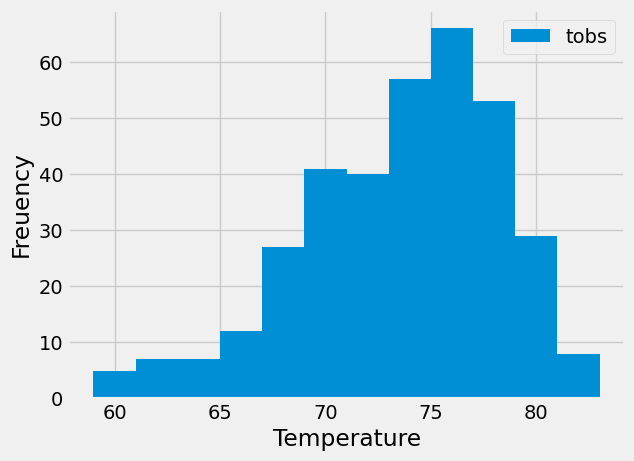

In [59]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
result_query = session.query(Measurement.tobs).filter(Measurement.station == active_stations_query[0][0]).filter(Measurement.date >= query_date).all()
temps = list(np.ravel(result_query))

sel = [Station.station, Station.name, Station.latitude, Station.longitude, Station.elevation]
result_query = session.query(*sel).all()
stations_data_df = pd.DataFrame(result_query, columns=['Station', 'Name', 'Latitude', 'Longitude', 'Elevation'])
stations_data_df

station_names = stations_data_df.loc[stations_data_df['Station'] == active_stations_query[0][0], 'Name'].tolist()
station_names

plt.hist(temps, bins=12, rwidth=1, label='tobs')
plt.xlabel('Temperature')
plt.ylabel('Freuency')
plt.legend()
plt.show()

# Close Session

In [60]:
# Close Session
session.close()
